In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype
import warnings
import optuna
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import BernoulliNB
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
import itertools
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from tabulate import tabulate
import os

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
## Data Preprocessing & EDA

train=pd.read_csv('Train_data.csv')
test=pd.read_csv('Test_data.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [4]:
train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate    class  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  anomaly  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [5]:
train.describe()

duration     src_bytes     dst_bytes          land  wrong_fragment  \
count  25192.000000  2.519200e+04  2.519200e+04  25192.000000    25192.000000   
mean     305.054104  2.433063e+04  3.491847e+03      0.000079        0.023738   
std     2686.555640  2.410805e+06  8.883072e+04      0.008910        0.260221   
min        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
25%        0.000000  0.000000e+00  0.000000e+00      0.000000        0.000000   
50%        0.000000  4.400000e+01  0.000000e+00      0.000000        0.000000   
75%        0.000000  2.790000e+02  5.302500e+02      0.000000        0.000000   
max    42862.000000  3.817091e+08  5.151385e+06      1.000000        3.000000   

            urgent           hot  num_failed_logins     logged_in  \
count  25192.00000  25192.000000       25192.000000  25192.000000   
mean       0.00004      0.198039           0.001191      0.394768   
std        0.00630      2.154202           0.045418      0.488811   
min        0.00000      0.000000           0.000000      0.000000   
25%        0.00000      0.000000           0.000000      0.000000   
50%        0.00000      0.000000           0.000000      0.000000   
75%        0.00000      0.000000           0.000000      1.000000   
max        1.00000     77.000000           4.000000      1.000000   

       num_compromised  ...  dst_host_count  dst_host_srv_count  \
count     25192.000000  ...    25192.000000        25192.000000   
mean          0.227850  ...      182.532074          115.063036   
std          10.417352  ...       98.993895          110.646850   
min           0.000000  ...        0.000000            0.000000   
25%           0.000000  ...       84.000000           10.000000   
50%           0.000000  ...      255.000000           61.000000   
75%           0.000000  ...      255.000000          255.000000   
max         884.000000  ...      255.000000          255.000000   

       dst_host_same_srv_rate  dst_host_diff_srv_rate  \
count            25192.000000            25192.000000   
mean                 0.519791                0.082539   
std                  0.448944                0.187191   
min                  0.000000                0.000000   
25%                  0.050000                0.000000   
50%                  0.510000                0.030000   
75%                  1.000000                0.070000   
max                  1.000000                1.000000   

       dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
count                 25192.000000                 25192.000000   
mean                      0.147453                     0.031844   
std                       0.308367                     0.110575   
min                       0.000000                     0.000000   
25%                       0.000000                     0.000000   
50%                       0.000000                     0.000000   
75%                       0.060000                     0.020000   
max                       1.000000                     1.000000   

       dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
count          25192.000000              25192.000000          25192.000000   
mean               0.285800                  0.279846              0.117800   
std                0.445316                  0.446075              0.305869   
min                0.000000                  0.000000              0.000000   
25%                0.000000                  0.000000              0.000000   
50%                0.000000                  0.000000              0.000000   
75%                1.000000                  1.000000              0.000000   
max                1.000000                  1.000000              1.000000   

       dst_host_srv_rerror_rate  
count              25192.000000  
mean                   0.118769  
std                    0.317333  
min                    0.000000  
25%                    0.000000  
50%                  

In [6]:
train.describe(include='object')

protocol_type service   flag   class
count          25192   25192  25192   25192
unique             3      66     11       2
top              tcp    http     SF  normal
freq           20526    8003  14973   13449

In [7]:
# Checking if ther is missing Data 

total = train.shape[0]
missing_col = [col for col in train.columns if train[col].isnull().sum() > 0]
for col in missing_col:
    null_count = train[col].isnull().sum()
    per = (null_count/total) * 100
    print(f"{col}: {null_count} ({round(per, 3)}%)")
    
    ## If there is nothing appear it's mean there is nothing is missing 
    

In [8]:
# Now Let's Check Duplicats


print(f"Number of Duplicates Rows: {train.duplicated().sum()}")

## If the result is 0 thats mean good.

Number of Duplicates Rows: 0


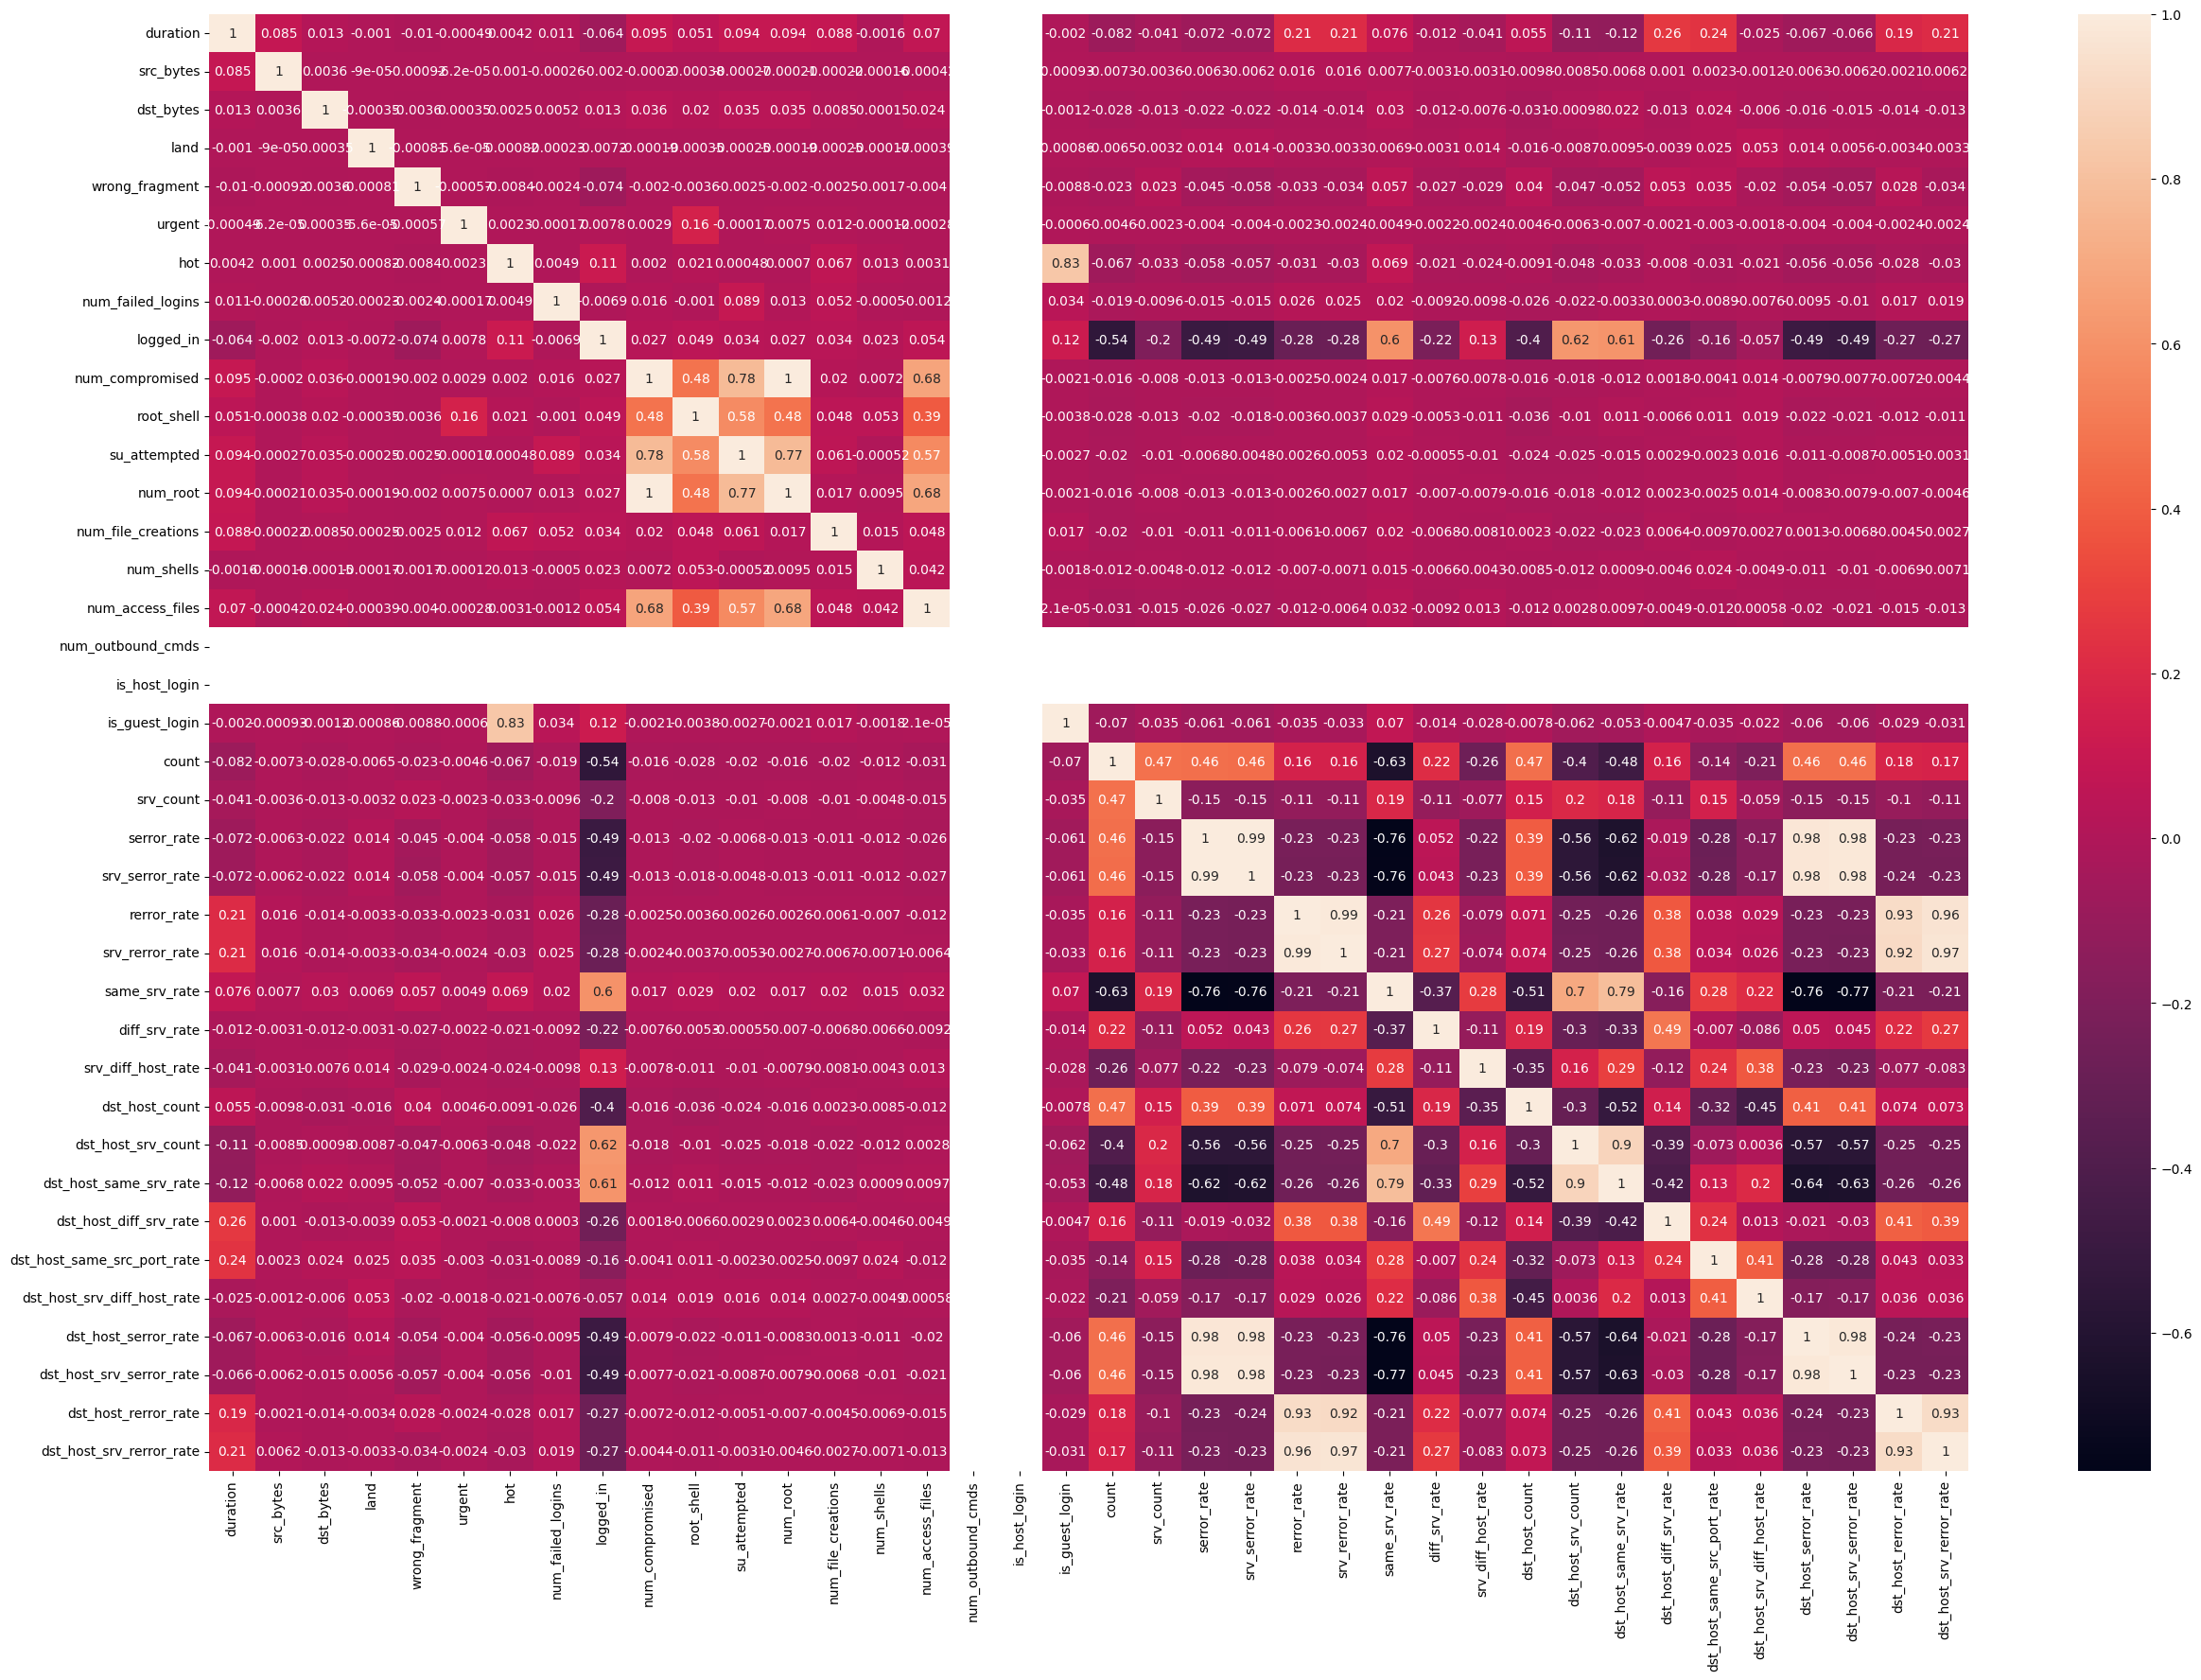

In [9]:
plt.figure(figsize=(30, 20))
sns.heatmap(train.corr(), annot=True)

import plotly.express as px
fig = px.imshow(train.corr(), text_auto=True, aspect="auto")
fig.show()

<AxesSubplot:xlabel='class', ylabel='count'>

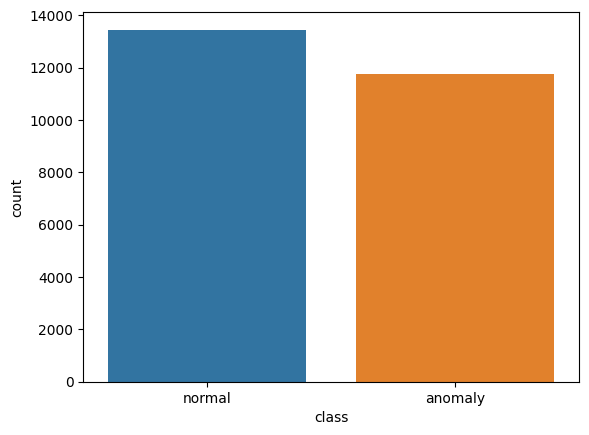

In [10]:
sns.countplot(x=train['class'])

In [11]:
# Now Label Encoding labels

def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            label_encoder = LabelEncoder()
            df[col] = label_encoder.fit_transform(df[col])
            
le(train)
le(test)

In [12]:
train.drop(['num_outbound_cmds'], axis=1, inplace=True)
test.drop(['num_outbound_cmds'], axis=1, inplace=True)
train.head()

duration  protocol_type  service  flag  src_bytes  dst_bytes  land  \
0         0              1       19     9        491          0     0   
1         0              2       41     9        146          0     0   
2         0              1       46     5          0          0     0   
3         0              1       22     9        232       8153     0   
4         0              1       22     9        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  class  
0                      0.00      1  
1                      0.00      1  
2                      0.00      0  
3                      0.01      1  
4                      0.00      1  

[5 rows x 41 columns]

In [13]:
# Feature Selections

X_train = train.drop(['class'], axis=1)
Y_train = train['class']

In [14]:
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select =10)
rfe = rfe.fit(X_train, Y_train)

feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X_train.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['protocol_type',
 'flag',
 'src_bytes',
 'dst_bytes',
 'count',
 'same_srv_rate',
 'diff_srv_rate',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate']

In [15]:
X_traintrain = X_train[selected_features]

In [16]:
## Now we are spliting and Scaling the data 

In [17]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
test = scale.fit_transform(test)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, train_size=0.90, random_state=2)


In [29]:
#  K Nearest Neighbors (KNN) classification model

def objective(trial):
    n_neighbors = trial.suggest_int('KNN_n_neighbors', 2, 16, log=False)
    classif_obj = KNeighborsClassifier(n_neighbors=n_neighbors)
    classif_obj.fit(x_train, y_train)
    accuracy = classif_obj.score(x_test, y_test)
    return accuracy

In [30]:
study_knn = optuna.create_study(direction='maximize')
study_knn.optimize(objective, n_trials=1)
print(study_knn.best_trial)

FrozenTrial(number=0, values=[0.9888888888888889], datetime_start=datetime.datetime(2022, 10, 14, 14, 17, 3, 288879), datetime_complete=datetime.datetime(2022, 10, 14, 14, 17, 3, 466307), params={'KNN_n_neighbors': 4}, distributions={'KNN_n_neighbors': IntDistribution(high=16, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)


In [31]:
KNN_model = KNeighborsClassifier(n_neighbors=study_knn.best_trial.params['KNN_n_neighbors'])
KNN_model.fit(x_train, y_train)

KNN_train, KNN_test = KNN_model.score(x_train, y_train), KNN_model.score(x_test, y_test)

print(f"Train Score: {KNN_train}")
print(f"Test Score: {KNN_test}")

Train Score: 0.9956333803810868
Test Score: 0.9888888888888889


In [32]:
# Logistic Regression Model

lg_model = LogisticRegression(random_state=42)
lg_model.fit( x_train, y_train)

LogisticRegression(random_state=42)

In [33]:
lg_train, lg_test = lg_model.score(x_train, y_train), lg_model.score(x_test, y_test)


print(f"Training Score: {lg_train}")
print(f"Test Score: {lg_test}")

Training Score: 0.9553634438955539
Test Score: 0.9488095238095238


In [39]:
# Decision Tree Classifier

def objective(trial):
    dt_max_depth = trial.suggest_int('dt_max_depth', 2, 32, log=False)
    dt_max_features = trial.suggest_int('dt_max_features', 2, 10, log=False)
    classif_obj = DecisionTreeClassifier(max_features=dt_max_features, max_depth = dt_max_depth)
    classif_obj.fit(x_train, y_train)
    accuracy = classif_obj.score(x_test, y_test)
    return accuracy

In [40]:
study_dt = optuna.create_study(direction='maximize')
study_dt.optimize(objective, n_trials=30)
print(study_dt.best_trial)

FrozenTrial(number=10, values=[0.9940476190476191], datetime_start=datetime.datetime(2022, 10, 14, 15, 15, 36, 753249), datetime_complete=datetime.datetime(2022, 10, 14, 15, 15, 36, 768884), params={'dt_max_depth': 25, 'dt_max_features': 5}, distributions={'dt_max_depth': IntDistribution(high=32, log=False, low=2, step=1), 'dt_max_features': IntDistribution(high=10, log=False, low=2, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=10, state=TrialState.COMPLETE, value=None)


In [42]:
dt = DecisionTreeClassifier(max_features= study_dt.best_trial.params['dt_max_features'], max_depth= study_dt.best_trial.params['dt_max_depth'])
dt.fit(x_train, y_train)

dt_train, dt_test = dt.score(x_train, y_train), dt.score(x_test, y_test)

print(f"Train Score: {dt_train}")
print(f"Test Score: {dt_test}")

Train Score: 0.9999558927311221
Test Score: 0.9944444444444445


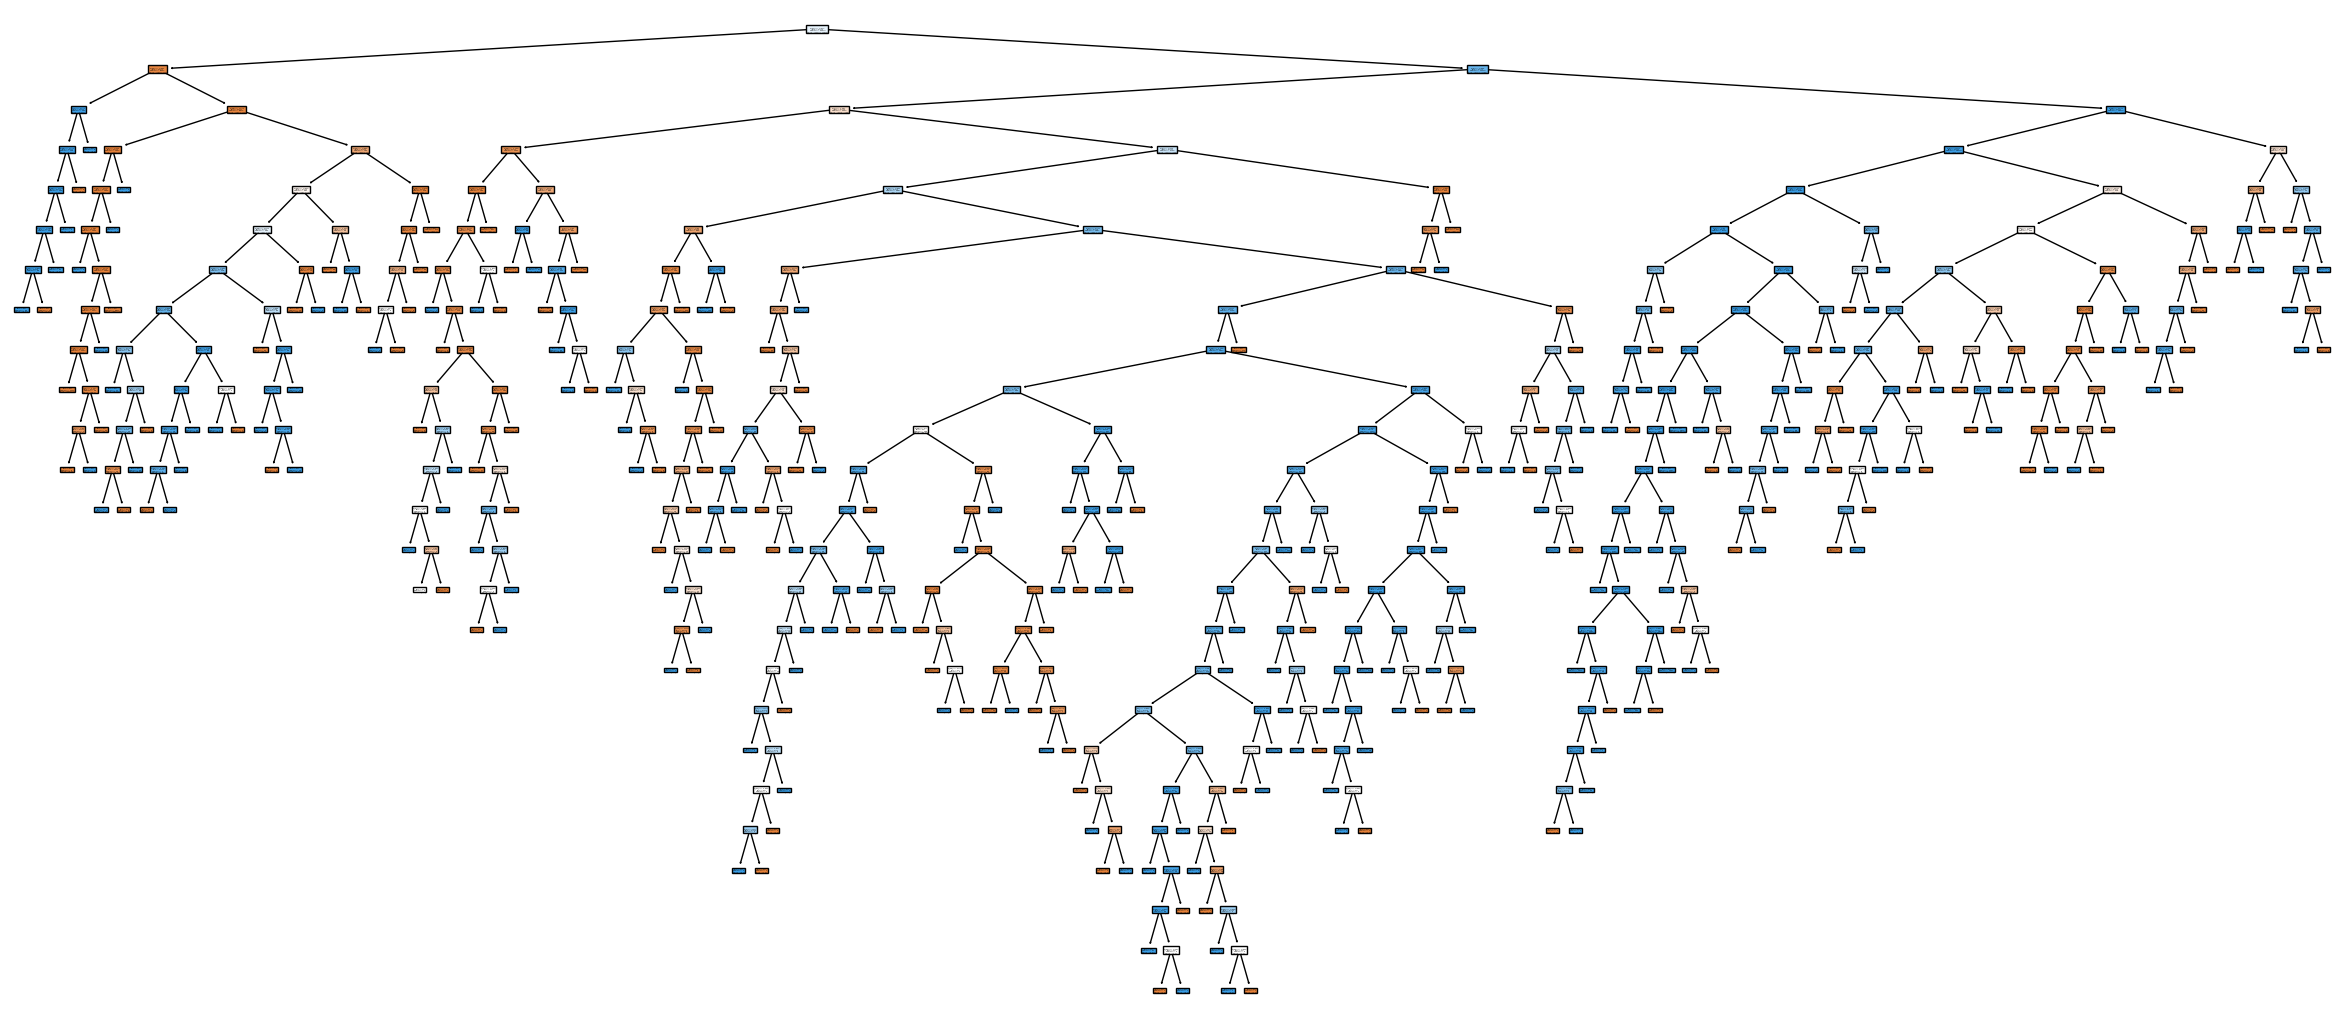

In [43]:
fig = plt.figure(figsize = (30, 13))
tree.plot_tree(dt, filled=True);
plt.show()

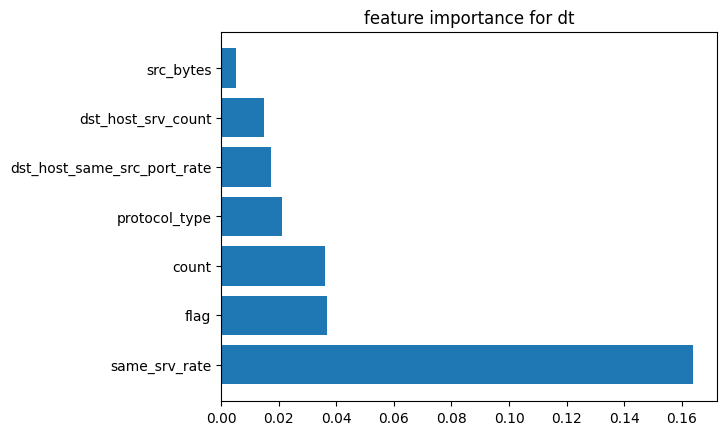

In [56]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))
    
    
    # Show all the features
    
    if top == -1:
        top = len(names)
        
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()
    
    
feature_names = selected_features
    
f_importance(abs(dt.feature_importances_), feature_names, top=7)

In [57]:
#Random Forest Classifier

def objective(trial):
    rf_mx_dep = trial.suggest_int('rf_mx_dep', 2, 32, log=False)
    rf_mx_fea = trial.suggest_int('rf_mx_fea', 2, 10, log=False)
    rf_mx_est = trial.suggest_int('rf_mx_est', 3, 20, log=False)
    classif_obj = RandomForestClassifier(max_features=rf_mx_fea, max_depth=rf_mx_dep, n_estimators = rf_mx_est )
    classif_obj.fit(x_train, y_train)
    accuracy = classif_obj.score(x_test, y_test)
    return accuracy

In [58]:
study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective, n_trials=30)
print(study_rf.best_trial)

FrozenTrial(number=17, values=[0.998015873015873], datetime_start=datetime.datetime(2022, 10, 14, 18, 54, 51, 430662), datetime_complete=datetime.datetime(2022, 10, 14, 18, 54, 51, 763347), params={'rf_mx_dep': 20, 'rf_mx_fea': 10, 'rf_mx_est': 20}, distributions={'rf_mx_dep': IntDistribution(high=32, log=False, low=2, step=1), 'rf_mx_fea': IntDistribution(high=10, log=False, low=2, step=1), 'rf_mx_est': IntDistribution(high=20, log=False, low=3, step=1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=17, state=TrialState.COMPLETE, value=None)


In [60]:
rf = RandomForestClassifier(max_features= study_rf.best_trial.params['rf_mx_fea'], max_depth=study_rf.best_trial.params['rf_mx_dep'], n_estimators = study_rf.best_trial.params['rf_mx_est'])
rf.fit(x_train, y_train)

rf_train, rf_test =rf.score(x_train, y_train), rf.score(x_test, y_test)

print(f"Train Score: {rf_train}")
print(f"Test Score: {rf_test}")


Train Score: 0.9999117854622441
Test Score: 0.9972222222222222


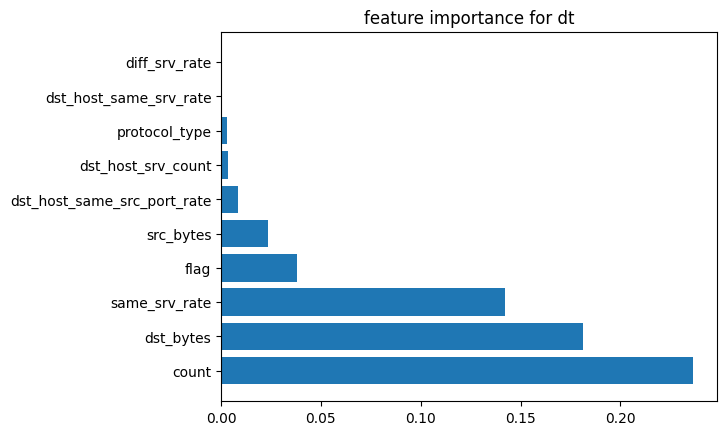

In [63]:
from matplotlib import pyplot as plt

def f_importance(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))
    
    if top == -1:
        top = len(names)
        
    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.title('feature importance for dt')
    plt.show()
    
features_names = selected_features

f_importance(abs(rf.feature_importances_), features_names, top=10)

In [64]:
## SKLearn Gradient Boosting Model

skgb = GradientBoostingClassifier(random_state=42)
skgb.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [66]:
skgb_train, skgb_test = skgb.score(x_train, y_train), skgb.score(x_test, y_test)

print(f"Training Score: {skgb_train}")
print(f"Test Score: {skgb_test}")

Training Score: 0.9964273112208892
Test Score: 0.9928571428571429


In [67]:
# XGBoost Gradient Boosting Model

xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [68]:
xgb_train, xgb_test = xgb_model.score(x_train , y_train), xgb_model.score(x_test , y_test)

print(f"Training Score: {xgb_train}")
print(f"Test Score: {xgb_test}")

Training Score: 0.9999558927311221
Test Score: 0.9972222222222222


In [ ]:
# Light Gradient Boosting Model


In [69]:
lgb_model = LGBMClassifier(random_state=42)
lgb_model.fit(x_train, y_train)

LGBMClassifier(random_state=42)

In [70]:
lgb_train, lgb_test = lgb_model.score(x_train , y_train), lgb_model.score(x_test , y_test)

print(f"Training Score: {lgb_train}")
print(f"Test Score: {lgb_test}")

Training Score: 0.9999558927311221
Test Score: 0.9976190476190476


In [72]:
# SKLearn AdaBoost Model
ab_model = AdaBoostClassifier(random_state=42)
ab_model.fit(x_train, y_train)


AdaBoostClassifier(random_state=42)

In [73]:
ab_train, ab_test = ab_model.score(x_train , y_train), ab_model.score(x_test , y_test)

print(f"Training Score: {ab_train}")
print(f"Test Score: {ab_test}")

Training Score: 0.9893701482004235
Test Score: 0.9857142857142858


In [74]:
# CatBoost Classifier Model
cb_model = CatBoostClassifier(verbose=0)


In [75]:
cb_model.fit(x_train, y_train)


In [76]:
cb_train, cb_test = cb_model.score(x_train , y_train), cb_model.score(x_test , y_test)

print(f"Training Score: {cb_train}")
print(f"Test Score: {cb_test}")

Training Score: 0.9988973182780522
Test Score: 0.9948412698412699


In [77]:
# Naive Baye Model
BNB_model = BernoulliNB()
BNB_model.fit(x_train, y_train)

BernoulliNB()

In [78]:
BNB_train, BNB_test = BNB_model.score(x_train , y_train), BNB_model.score(x_test , y_test)

print(f"Training Score: {BNB_train}")
print(f"Test Score: {BNB_test}")

Training Score: 0.8969213126323218
Test Score: 0.8896825396825396


In [79]:
# Voting Model
v_clf = VotingClassifier(estimators=[('KNeighborsClassifier', KNN_model), ("XGBClassifier", xgb_model), ("RandomForestClassifier", rf), ("DecisionTree", dt), ("XGBoost", xgb_model), ("LightGB", lgb_model), ("AdaBoost", ab_model), ("Catboost", cb_model)], voting = "hard")


In [80]:
v_clf.fit(x_train, y_train)


VotingClassifier(estimators=[('KNeighborsClassifier',
                              KNeighborsClassifier(n_neighbors=4)),
                             ('XGBClassifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_ty...
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=42,
                                            reg_alpha=0, reg_lambda=1, ...)),
                             ('LightGB', LGBMClassifier(random_state=42)),
                             ('AdaBoost', AdaBoostClassifier(random_state=42)),
                             ('Catboost',
                              <catboost.core.CatBoostClassifier object at 0x0000020D50E373D0>)])

In [81]:
voting_train, voting_test = v_clf.score(x_train , y_train), v_clf.score(x_test , y_test)

print(f"Training Score: {voting_train}")
print(f"Test Score: {voting_test}")

Training Score: 0.9999558927311221
Test Score: 0.9976190476190476


In [82]:
# SVM Model
def objective(trial):
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'linearSVC'])
    c = trial.suggest_float('c', 0.02, 1.0, step=0.02)
    if kernel in ['linear', 'rbf']:
        classifier_obj = SVC(kernel=kernel, C=c).fit(x_train, y_train)
    elif kernel == 'linearSVC':
        classifier_obj = LinearSVC(C=c).fit(x_train, y_train)
    elif kernel == 'poly':
        degree = trial.suggest_int('degree', 2, 10)
        classifier_obj = SVC(kernel=kernel, C=c, degree=degree).fit(x_train, y_train)
        
    accuracy = classifier_obj.score(x_test, y_test)
    return accuracy

In [83]:
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(objective, n_trials=30)
print(study_svm.best_trial)

FrozenTrial(number=12, values=[0.986904761904762], datetime_start=datetime.datetime(2022, 10, 14, 22, 48, 40, 636318), datetime_complete=datetime.datetime(2022, 10, 14, 22, 48, 43, 419229), params={'kernel': 'rbf', 'c': 1.0}, distributions={'kernel': CategoricalDistribution(choices=('linear', 'rbf', 'poly', 'linearSVC')), 'c': FloatDistribution(high=1.0, log=False, low=0.02, step=0.02)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=12, state=TrialState.COMPLETE, value=None)


In [84]:
if study_svm.best_trial.params['kernel'] in ['linear', 'rbf']:
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'])
elif kernel == 'linearSVC':
    SVM_model = LinearSVC(C=study_svm.best_trial.params['c'])
elif kernel == 'poly':
    SVM_model = SVC(kernel=study_svm.best_trial.params['kernel'], C=study_svm.best_trial.params['c'], degree=study_svm.best_trial.params['degree'])

SVM_model.fit(x_train, y_train)

SVC()

In [85]:
SVM_train, SVM_test = SVM_model.score(x_train , y_train), SVM_model.score(x_test , y_test)

print(f"Training Score: {SVM_train}")
print(f"Test Score: {SVM_test}")

Training Score: 0.9921047988708539
Test Score: 0.986904761904762


In [87]:
## Summary

data = [["KNN", KNN_train, KNN_test], 
        ["Logistic Regression", lg_train, lg_test],
        ["Decision Tree", dt_train, dt_test], 
        ["Random Forest", rf_train, rf_test], 
        ["GBM", skgb_train, skgb_test], 
        ["XGBM", xgb_train, xgb_test], 
        ["Adaboost", ab_train, ab_test], 
        ["light GBM", lgb_train, lgb_test],
        ["CatBoost", cb_train, cb_test], 
        ["Naive Baye Model", BNB_train, BNB_test], 
        ["Voting", voting_train, voting_test],
        ["SVM", SVM_train, SVM_test]]

col_names = ["Model", "Train Score", "Test Score"]
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════════════════╤═══════════════╤══════════════╕
│ Model               │   Train Score │   Test Score │
╞═════════════════════╪═══════════════╪══════════════╡
│ KNN                 │      0.995633 │     0.988889 │
├─────────────────────┼───────────────┼──────────────┤
│ Logistic Regression │      0.955363 │     0.94881  │
├─────────────────────┼───────────────┼──────────────┤
│ Decision Tree       │      0.999956 │     0.994444 │
├─────────────────────┼───────────────┼──────────────┤
│ Random Forest       │      0.999912 │     0.997222 │
├─────────────────────┼───────────────┼──────────────┤
│ GBM                 │      0.996427 │     0.992857 │
├─────────────────────┼───────────────┼──────────────┤
│ XGBM                │      0.999956 │     0.997222 │
├─────────────────────┼───────────────┼──────────────┤
│ Adaboost            │      0.98937  │     0.985714 │
├─────────────────────┼───────────────┼──────────────┤
│ light GBM           │      0.999956 │     0.997619 │
├─────────